# Processing the drifting buoy data

Drift tracks from instruments deployed during the MOSAiC campaign were obtained from the Arctic Data Center and saved in the folder `data/adc_dn_tracks`. The "DN" stands for "Distributed Network", which is a set of autonomous stations deployed surrounding a heavily-instrumented crewed observatory as it drifted across the Arctic from 2019-2020. 

For this project, we need quality-controlled buoy positions at hourly resolution. The raw data is at a variety of time resolutions, from 5 minutes to 12-hourly, and the resolution may change across the lifetime of a buoy. (This is not accidental--high time resolution comes at a cost of battery life. So some buoys were switched to high time resolution, for example, when storms were forecast, so that the rapid ice motion in response to the fast-moving storm system could be captured).

The files in `scripts/icedrift` contain functions for buoy processing that are in the process of being added to an open-source library. For now, since the library has not yet been listed at conda-forge or similar repositories, we'll add the package directly by adding the scripts folder to the path.

In [1]:
import sys
sys.path.append('../scripts')
import proplot as pplt
import pandas as pd
import cartopy.crs as ccrs
from helpers import *

def print(*val):
    display(*val)

In [2]:
# You can run the processing code as a cell magic like this
# or run it separately in the command line

# %run ../scripts/process_mosaic.py

To get more familiar with the data, try the following tasks.

1. Choose a buoy with high temporal resolution (low f_min). Use Pandas to load the buoy data from the original folder, the qc_buoys folder, and from the interp_buoys folder. How do the time series differ? Did the quality control step remove many observations? Does the lower-frequency interpolated data  appear to represent the high-frequency data well?
2. Choose a buoy with lower temporal resolution (f_min of 240). Repeat the same process as in (1). How does the data quality compare, from what you can tell? Does the interpolation process appear at this stage to add unrealistic features? (You'll get more of a feel for what's realistic or not as we go, and as we calculate other quantities from the buoy trajectories)
3. Choose two buoys. How similar are the paths that they take?
4. Find a buoy where the raw track has f_min close to 60 minutes and the qc_track is a different length. Can you find where the QC process flagged and dropped observations? Do you agree with the algorithm's choices?
5. Using Cartopy or ProPlot, make a geographic plot showing the buoy trajectories. Make the buoy tracks for DN1 and DN2 different colors. (I recommend a North Polar Stereographic map projection)


## 1.

(Figure(nrows=3, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=3, ncols=2, length=6))

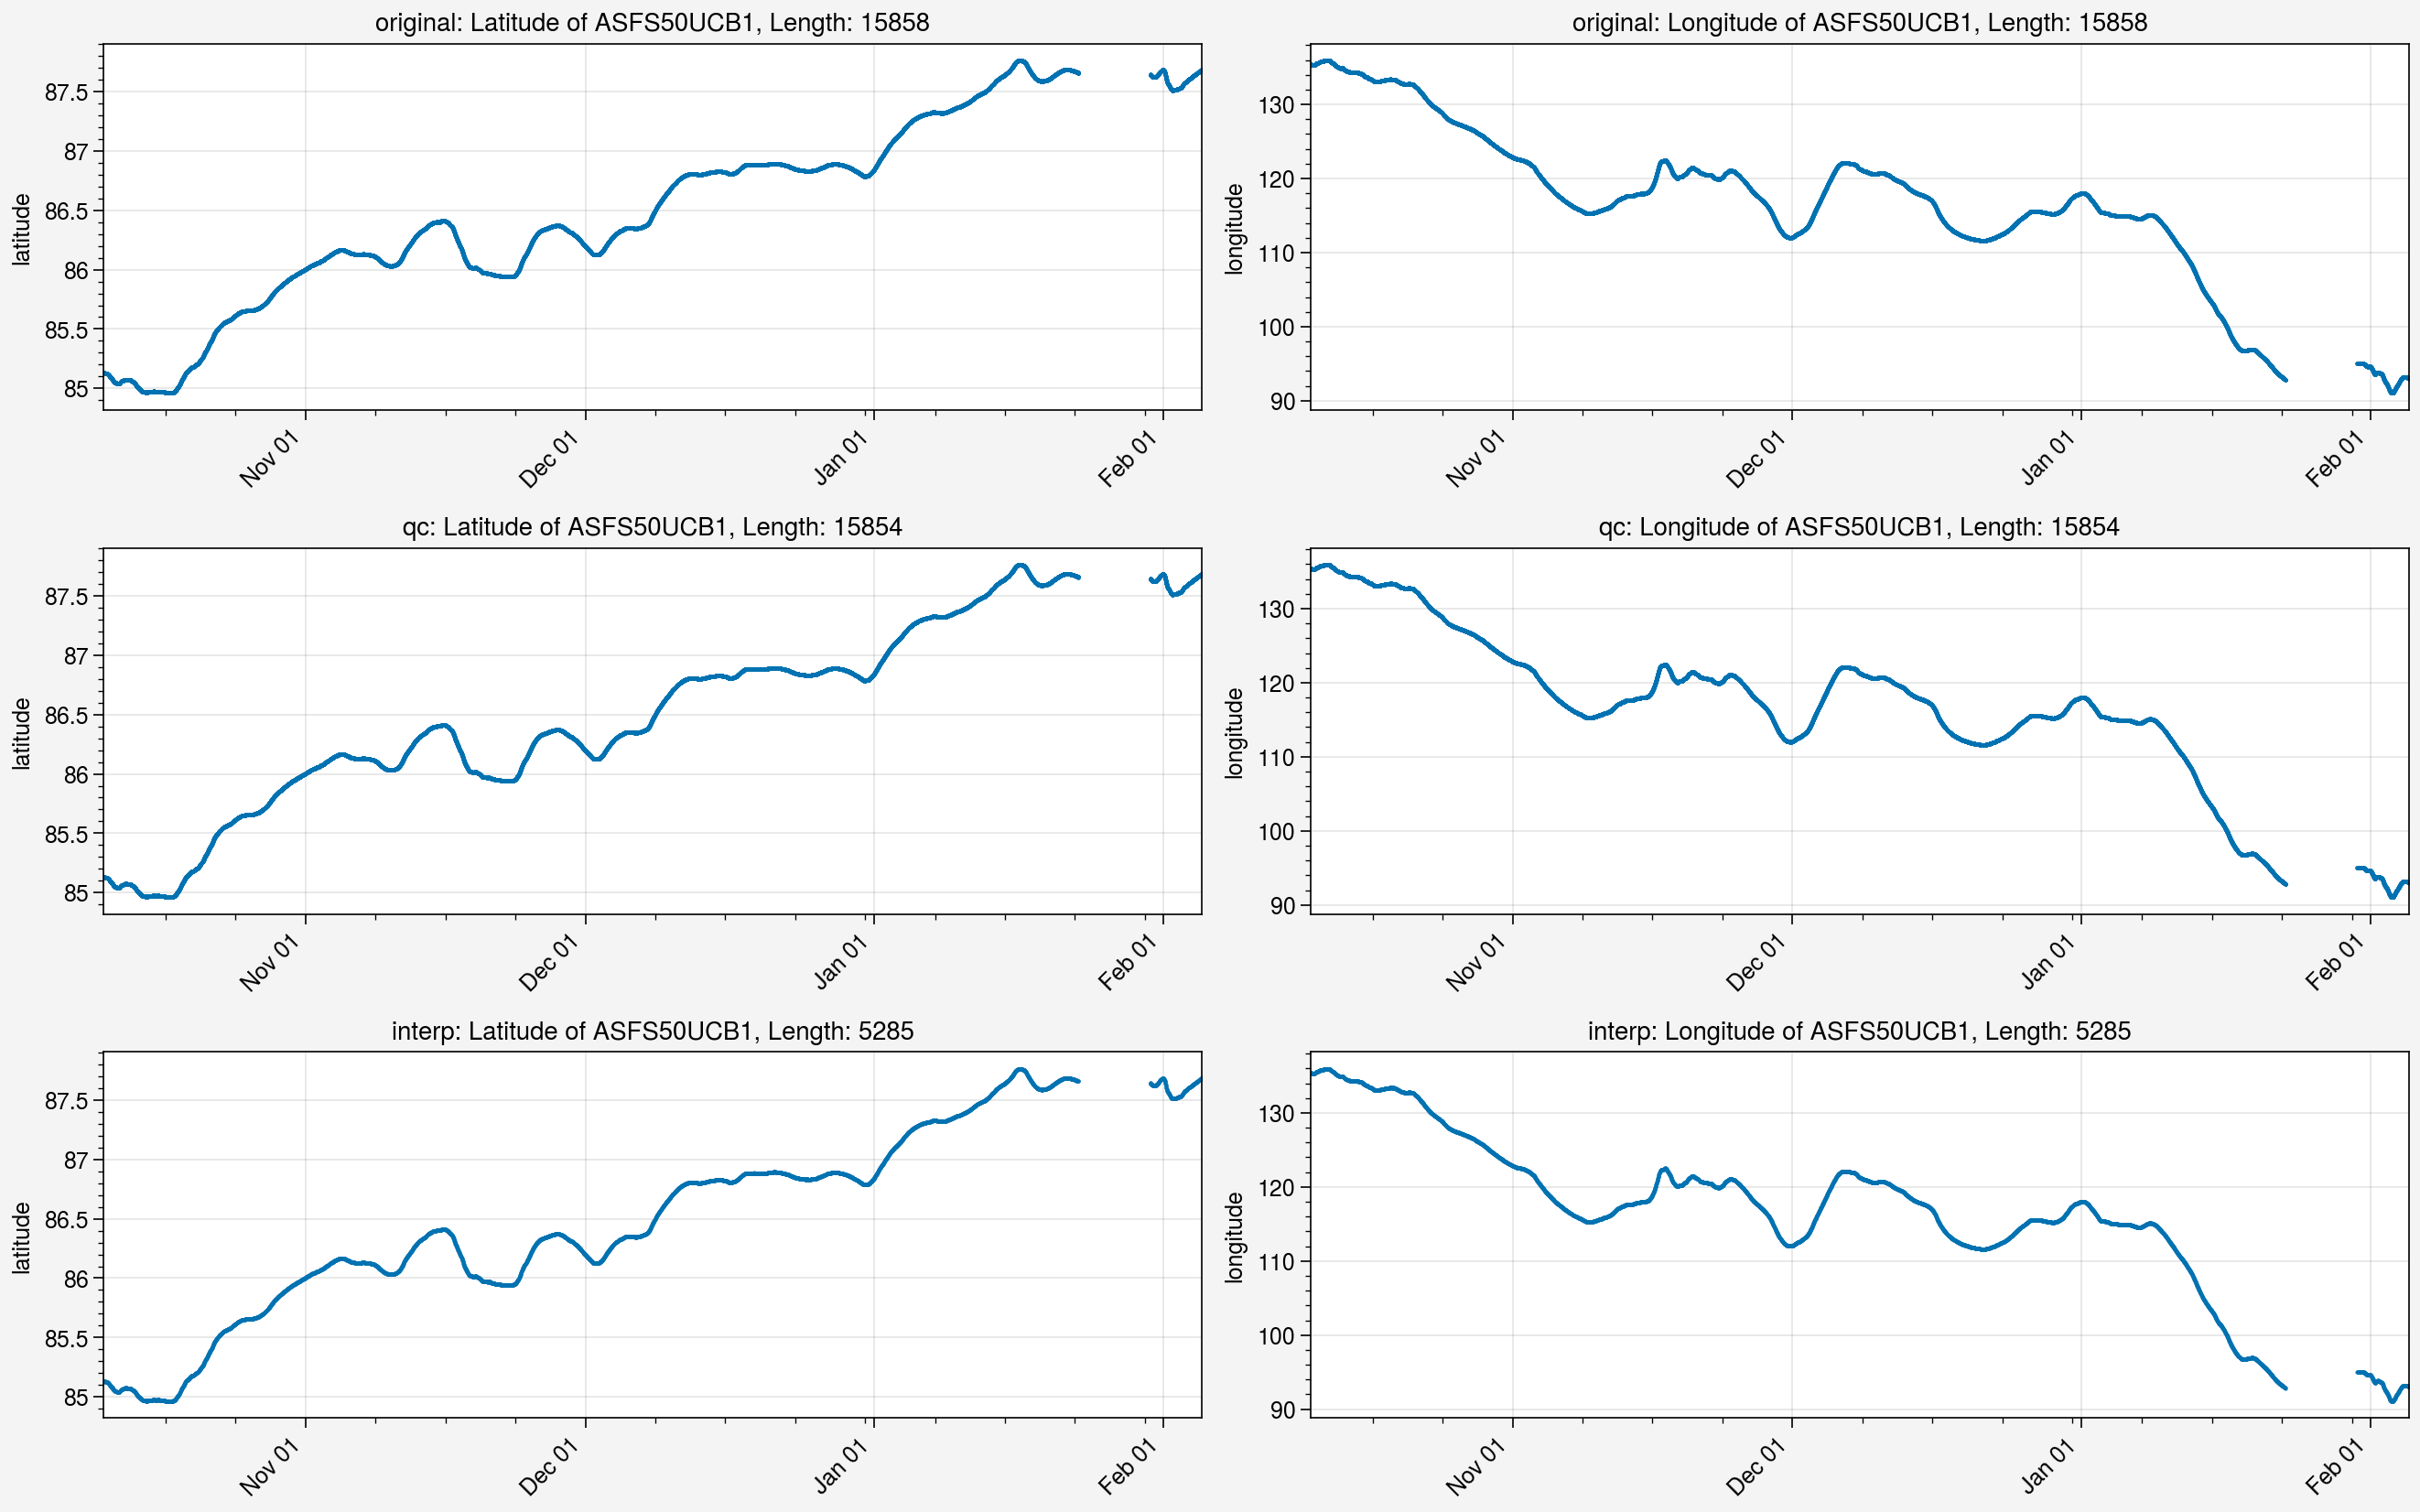

In [3]:
# print(metadata[metadata['Calculated Frequency'] == '30min'].index)
buoy_data("ASFS50UCB1")
graph_data("ASFS50UCB1")

There is significantly less data in the interpolated dataframe. Quality control didn't do much, only removing 4 data points. It seems that the interpolation function reduced granularity by a factor of 3 from 10 minute intervals to 30 minute intervals. Looking at the graphs, the low frequency data still seems to represent the high frequency data well. I'm not sure why the interpolation function reduces frequency that much though.

# 2.

(Figure(nrows=3, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=3, ncols=2, length=6))

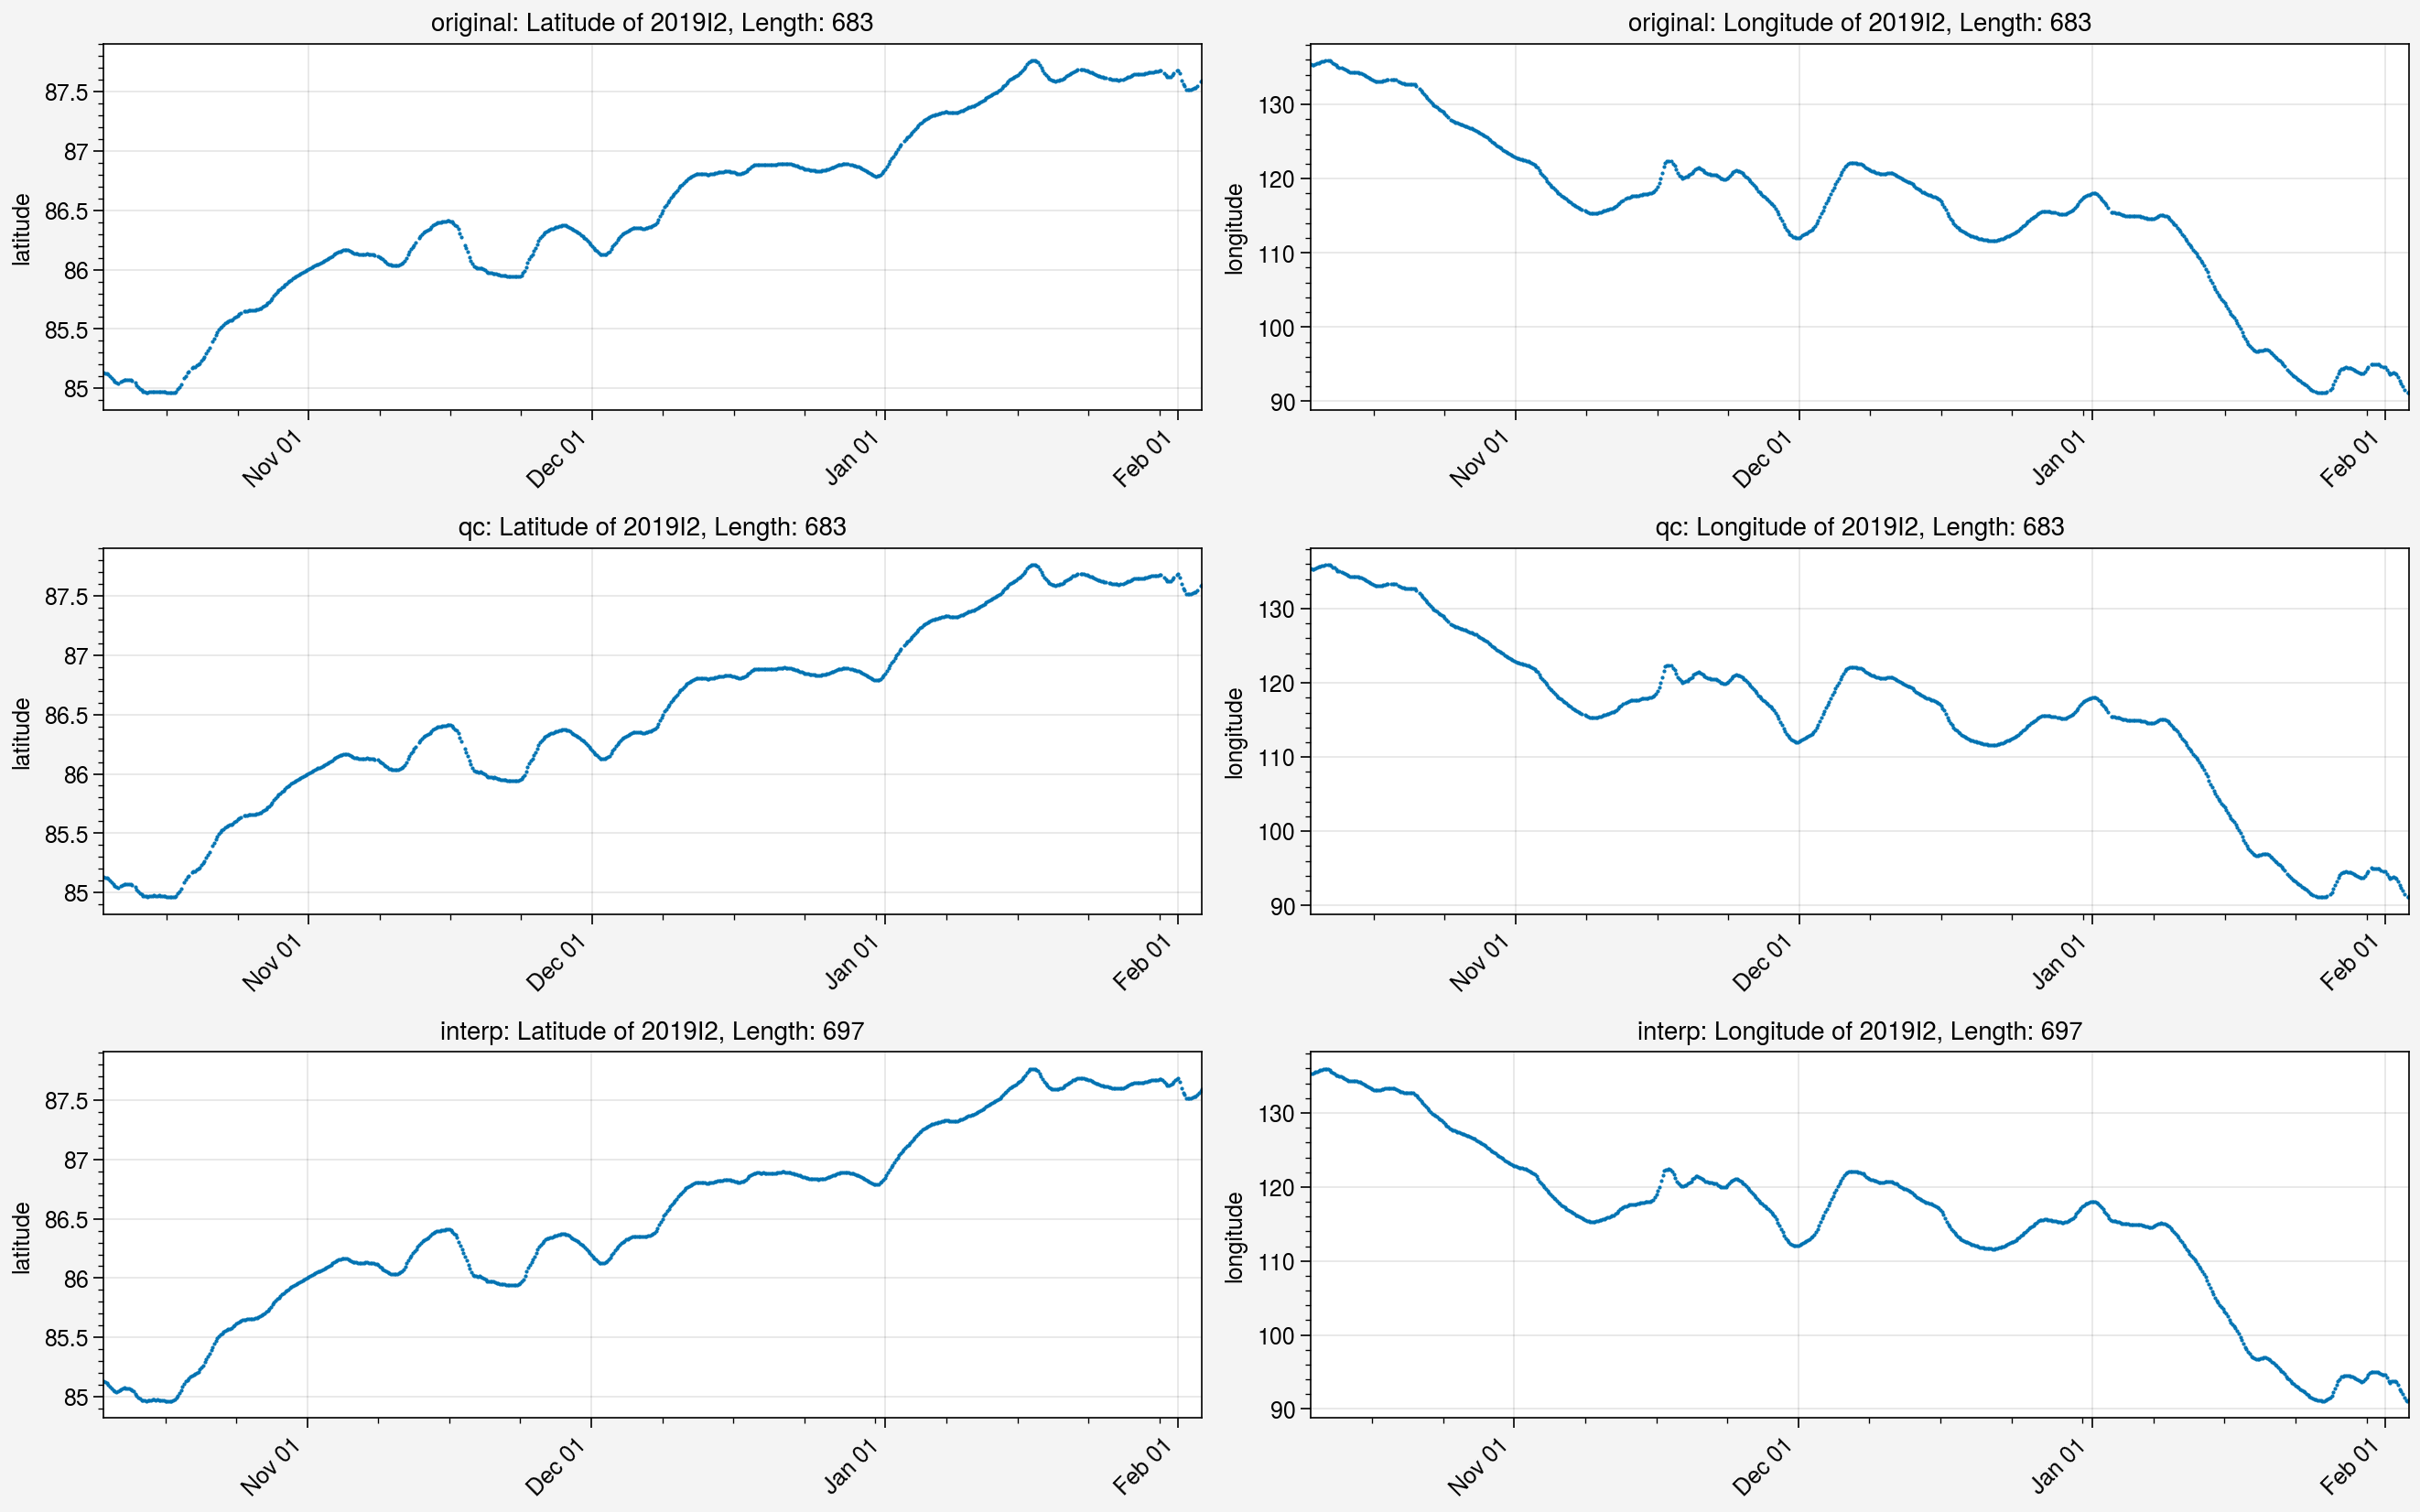

In [4]:
# print(freq_lookup[freq_lookup.freq == '240min'])
graph_data("2019I2", showcleaned=True)

It doesn't seem like interpolation added unrealistic qualities, but rather quality control. In this case, quality control added a huge jump at the beginning of the data, as if the ice teleported in latitude by more than 0.5 degrees. Also, it seems ot have removed the first and last three days of data.

Let's take a closer look to see why the QC function would have dropped those observations.


/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:


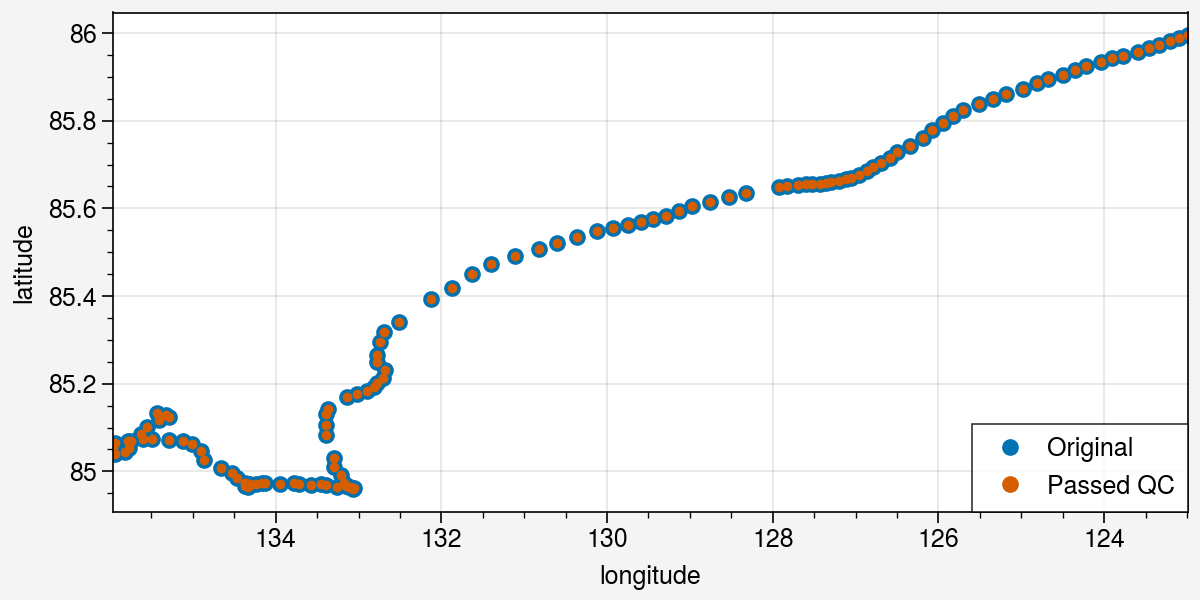

In [5]:
time_slice = slice('2019-10-01', '2019-10-31')
buoy_orig = buoy_data('2019I2', 'original')
buoy_qc = buoy_data('2019I2', 'qc')
orig_df = buoy_orig.set_index('datetime')
qc_df = buoy_qc.set_index('datetime')

fig, ax = pplt.subplots(width=6, height=3)
ax.plot(orig_df.loc[time_slice, 'longitude'],
        orig_df.loc[time_slice, 'latitude'], m='.', ms=10, lw=0, label='Original')
ax.plot(qc_df.loc[time_slice, 'longitude'],
        qc_df.loc[time_slice, 'latitude'], m='.', ms=5, lw=0, label='Passed QC')
ax.legend(loc='lr', ncols=1, markersize=10)

Hmm. This is a big gap. Recall that one criterion for the QC is the gap between observations. Let's look at the time interval in between rows.

<a list of 1 Line2D objects>

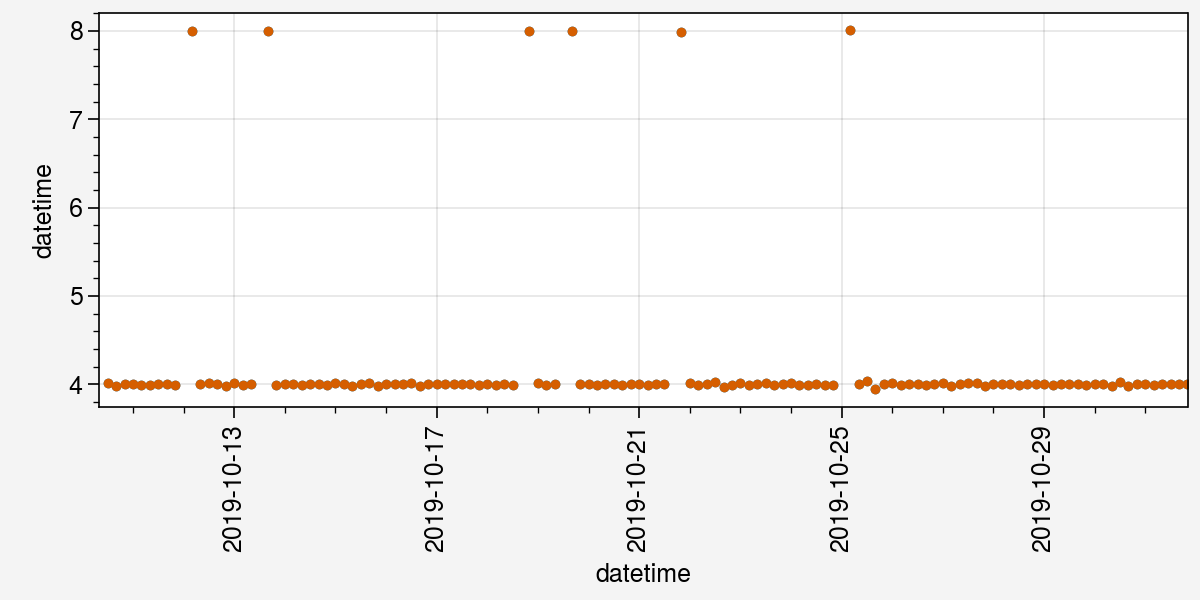

In [6]:
time_since_previous = orig_df.index.to_series() - orig_df.index.to_series().shift(1)
time_since_previous = time_since_previous.dt.total_seconds()/(60*60) # conver to hours
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(time_since_previous.loc[time_slice], marker='.', ms=5, lw=0)
ax.plot(time_since_previous.loc[qc_df.index].loc[time_slice], marker='.', ms=5, lw=0)

In [7]:
buoy_metadata().loc['2019I2']

Deployment Leg                                          1
DN Station ID                                          L2
IMEI                                      300434063384820
Deployment Date                                2019-10-07
Deployment Datetime                   2019-10-07 05:43:00
First Data Datetime                   2019-10-10 08:01:18
Last Data Datetime                    2020-02-03 12:07:34
Active                                                  0
Sampling Frequency (hh:mm)                          04:00
Re-deployed As                                        NaN
Formerly Deployed As                                  NaN
Buoy Type                                    Seasonal IMB
Manufacturer                                      CryoInn
Model                                               SIMB3
PI                                               Perovich
Data Authors                  Ryleigh Moore; Don Perovich
Calculated Frequency                               240min
Name: 2019I2, 

OK, so this makes sense! This buoy has rather low frequency, at 4 hours. The gap frequency is set to 6 hours in the `standard_qc` function. Any gap larger than 6 hours--which in this case happens any time that a single observation is missing--triggers the flag in the `check_gaps` function. The reason for setting this to 6 hours is that for the study that I set up the code for, we needed to be able to resolve processes happening over short time intervals. In that project I was only using the buoys that had median frequency of 3 hours or faster. Interpolating to fill a 6 hour gap add non-realistic signals to the calculations. 

For this project, we can use a larger set of buoys, at least for the portion where we are looking at 12 hour and 24 hour displacements. Since the interpolation function is set to not go to higher frequencies than the sensor's median frequency, we should change the QC setting to be adaptive as well. To address this, I suggest you do the following:

1. Move the lines calling `get_frequency` to before the `standard_qc` function is called
2. Change the gap threshold to be an integer multiple of the frequency (3 is probably a good starting point here). You'll need to convert the frequency from a string into an integer, keeping track of units, apply the multiplication, then convert it back into a string with the time interval units.

# 3.

In [8]:
print(buoy_metadata()[buoy_metadata()["Calculated Frequency"] == '30min'].head(10).index)

Index(['2019O1', '2019O2', '2019O3', '2019O4', '2019O5', '2019O6', '2019O7',
       '2019O8', '2019P101', '2019P102'],
      dtype='object', name='Sensor ID')

(Figure(nrows=1, ncols=2, refwidth=6.0, refheight=2.0),
 SubplotGrid(nrows=1, ncols=2, length=2))

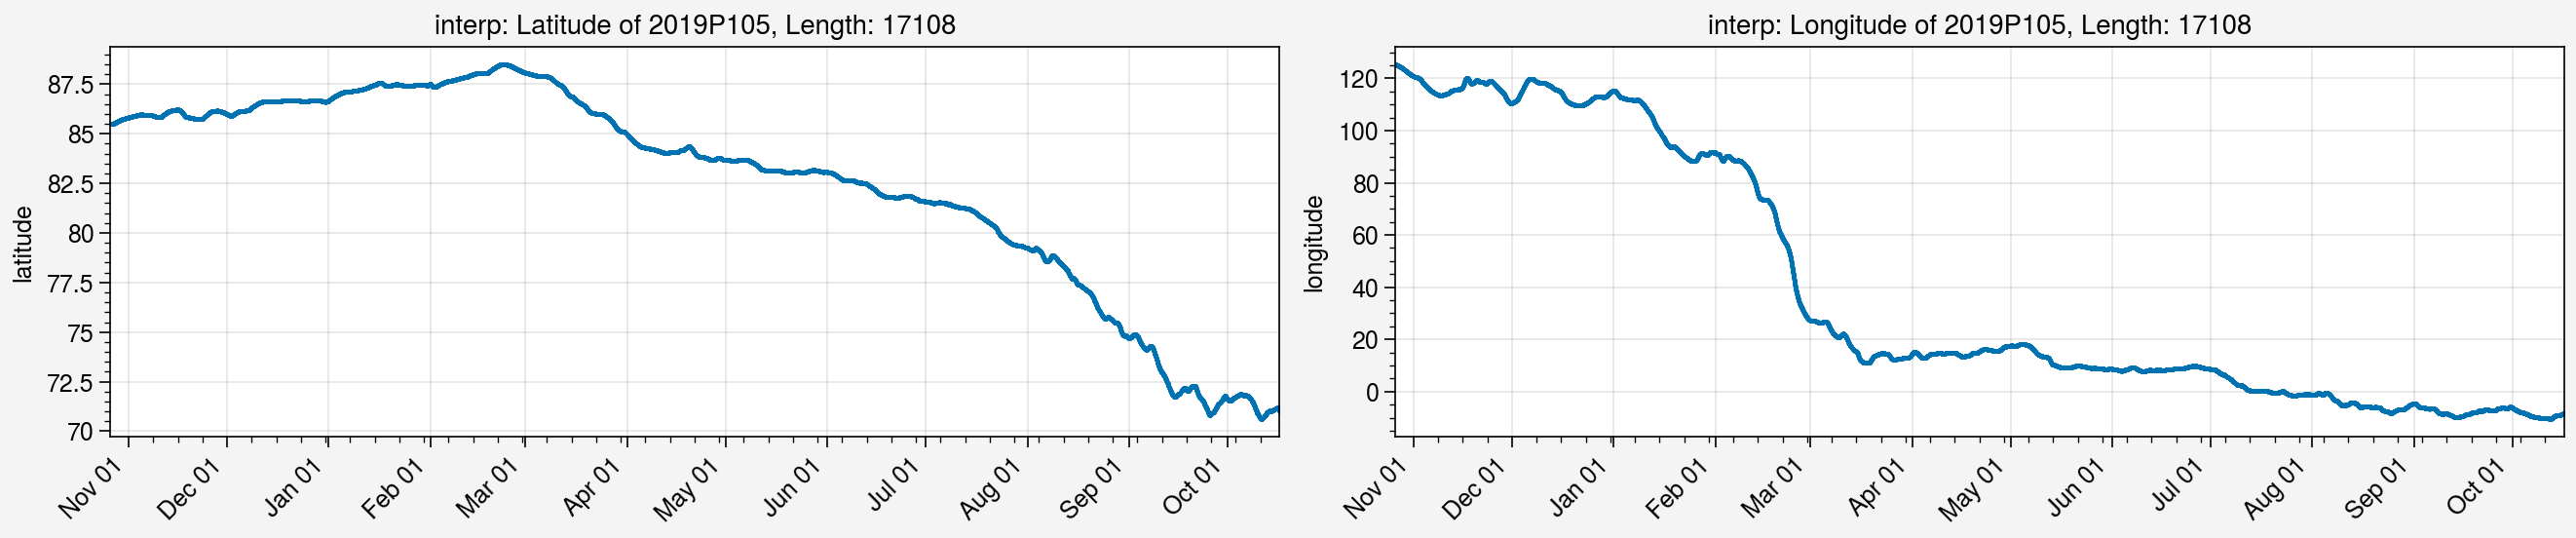

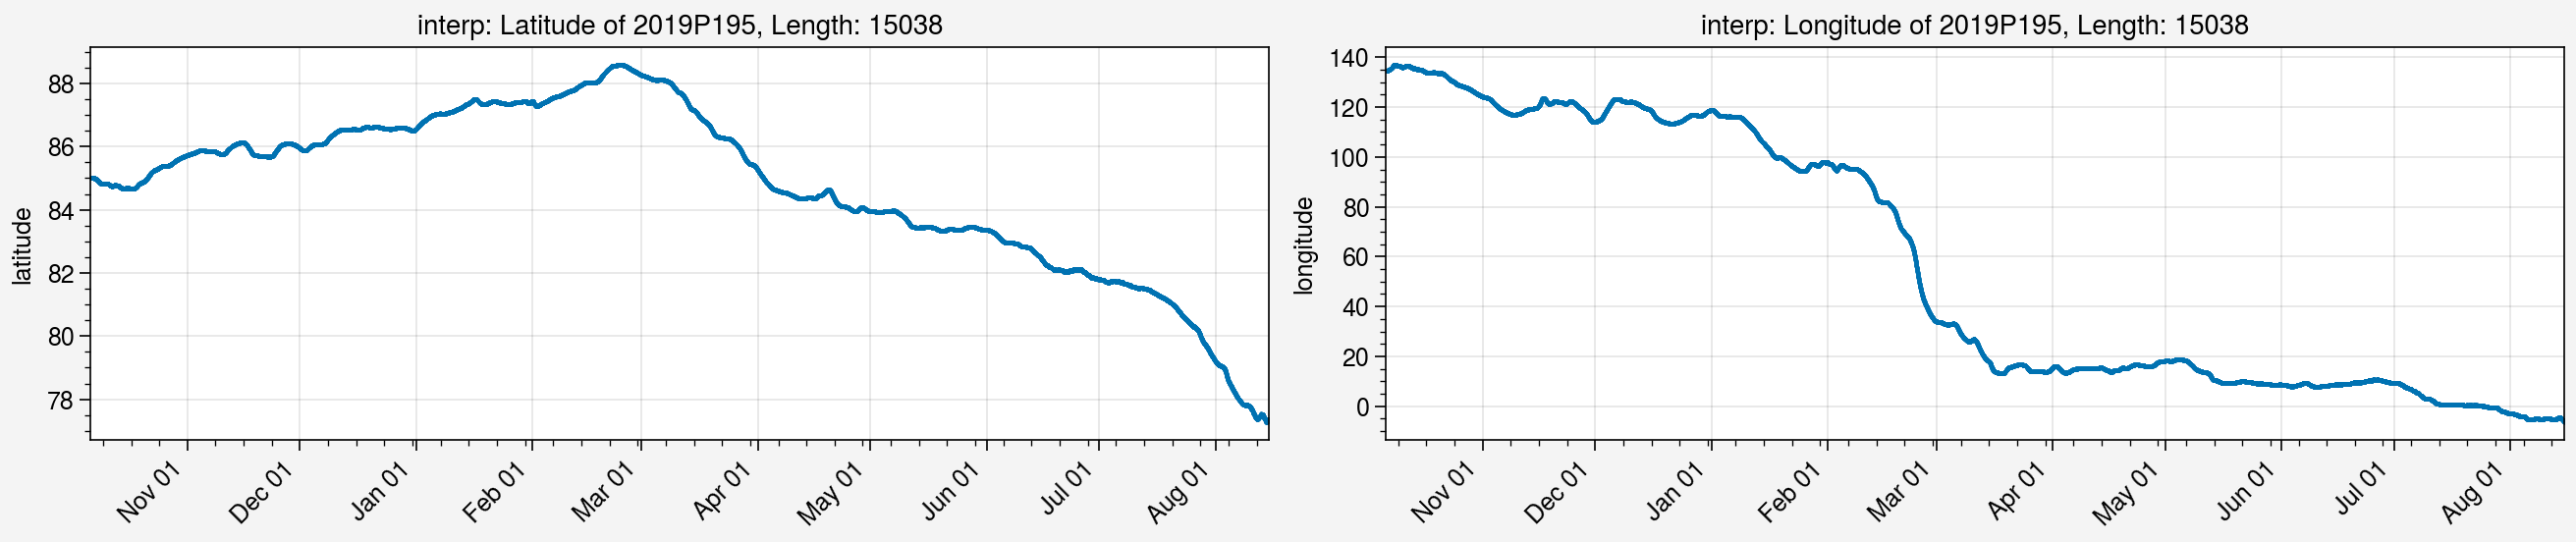

In [9]:
buoy1 = "2019P105"
buoy2 = "2019P195"

if buoy_metadata().loc[buoy1]["Deployment Leg"] != buoy_metadata().loc[buoy2]["Deployment Leg"]:
    raise "Buoys not same deployment leg"

buoy1_data = buoy_data(buoy1, 'interp').add_suffix("1")[['latitude1','longitude1']]
buoy2_data = buoy_data(buoy2, 'interp').add_suffix("2")[['latitude2','longitude2']]

# Join the data for the two buoys into one dataframe
joined_data = buoy1_data.join(buoy2_data).dropna()

graph_data(buoy1, include=["interp"])
graph_data(buoy2, include=["interp"])

In [10]:
# Calculated the correlation in latitude drift and longitude drift separately
# Used both original and differenced data

diff_data = (joined_data - joined_data.shift(1)).dropna()

lats_corr = joined_data[["latitude1","latitude2"]].corr().loc["latitude1","latitude2"]
lons_corr = joined_data[["longitude1","longitude2"]].corr().loc["longitude1","longitude2"]

diff_lats = diff_data[["latitude1","latitude2"]].corr().loc["latitude1","latitude2"]
diff_lons = diff_data[["longitude1","longitude2"]].corr().loc["longitude1","longitude2"]

print(f"Latitude correlation: {lats_corr}")
print(f"Longitude correlation: {lons_corr}")
print(f"Latitude differenced correlation: {diff_lats}")
print(f"Longitude differenced correlation: {diff_lons}")

'Latitude correlation: 0.9517051627450672'

'Longitude correlation: 0.958068688780011'

'Latitude differenced correlation: 0.1985621226375718'

'Longitude differenced correlation: 0.040058157369132694'

In [11]:
from icedrift.analysis import compute_velocity
buoy1_data = buoy_data(buoy1, 'interp')
buoy2_data = buoy_data(buoy2, "interp")
buoy1_data = compute_velocity(buoy1_data.set_index('datetime'))
buoy2_data = compute_velocity(buoy2_data.set_index('datetime'))

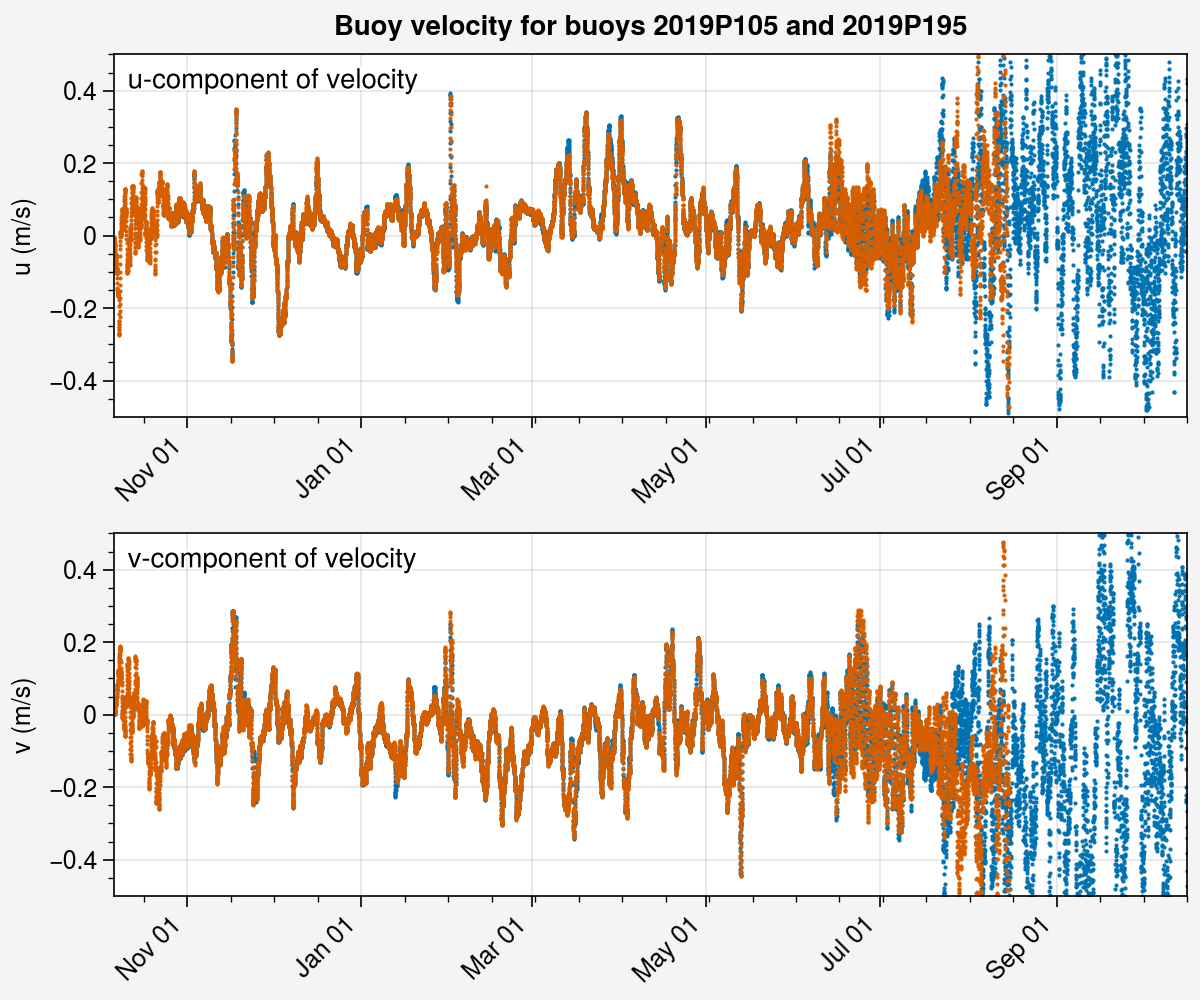

In [12]:
fig, axs = pplt.subplots(width=6, height=5, nrows=2, share=False)
for ax, component in zip(axs, ['u', 'v']):
    ax.plot(buoy1_data[component], lw=0, marker='.', ms=1)
    ax.plot(buoy2_data[component], lw=0, marker='.', ms=1)
    ax.format(ultitle=component + '-component of velocity', xrotation=45, xformatter='%b %d',
              xlabel='', ylabel=component + ' (m/s)', ylim=(-0.5, 0.5))
fig.format(suptitle='Buoy velocity for buoys {b1} and {b2}'.format(b1=buoy1, b2=buoy2))


Quick look at correlation. Note: for a full analysis of correlation, you'd need to do a significance test accounting for the fact that the velocity data are highly autocorrelated, so the effective sample size is lower than the length of the time series.

In [13]:
buoy1_data.corrwith(buoy2_data, method='spearman')

x_stere             0.999379
y_stere             0.999937
data_gap_minutes   -0.004888
longitude           0.998409
latitude            0.998099
x                   0.999379
y                   0.999937
u                   0.872920
v                   0.865510
speed               0.929256
dtype: float64

# 4.

In [14]:
# Get only the buoys that have frequency 60 and have been affected by quality control

meta = buoy_metadata()
freq60buoys = meta[meta['Calculated Frequency'] == '60min']

freq60buoys = freq60buoys.assign(orig_length = [len(buoy_data(name, 'original')) if usable_buoy(name) else 0 for name in freq60buoys.index])
freq60buoys = freq60buoys.assign(qc_length = [len(buoy_data(name, 'qc')) if usable_buoy(name) else 0 for name in freq60buoys.index])

print(freq60buoys[freq60buoys.orig_length != freq60buoys.qc_length].index)

Index(['2019P112', '2019P113', '2019P114', '2019P119', '2019P123', '2019P124',
       '2019P125', '2019P127', '2019P128', '2019P136', '2019P139', '2019P144',
       '2019P150', '2019P151', '2019P152', '2019P155', '2019P156', '2019P157',
       '2019P158', '2019P159', '2019R8', '2019R9', '2019S84', '2019S86',
       '2019S94', '2019S96', '2019T69', '2019V1', '2019V2', '2019V3', '2019V4',
       '2020E2', '2020E3', '2020M23', '2020P160', '2020P162', '2020P170',
       '2020P171', '2020P172', '2020P173', '2020P175', '2020P177', '2020P180',
       '2020P181', '2020P212', '2020P213', '2020P225', '2020P227', '2020P228',
       '2020P229', '2020P231', '2020P233', '2020P234', '2020P236', '2020P237',
       '2020R10', '2020R11', '2020R12', '2020S105', '2020S106', '2020S107',
       '2020S108', '2020S97', '2020S98', '2020S99'],
      dtype='object', name='Sensor ID')

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:
/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/proplot/axes/plot.py:1898: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if autox and autoreverse and x.ndim == 1 and x.size > 1 and x[1] < x[0]:


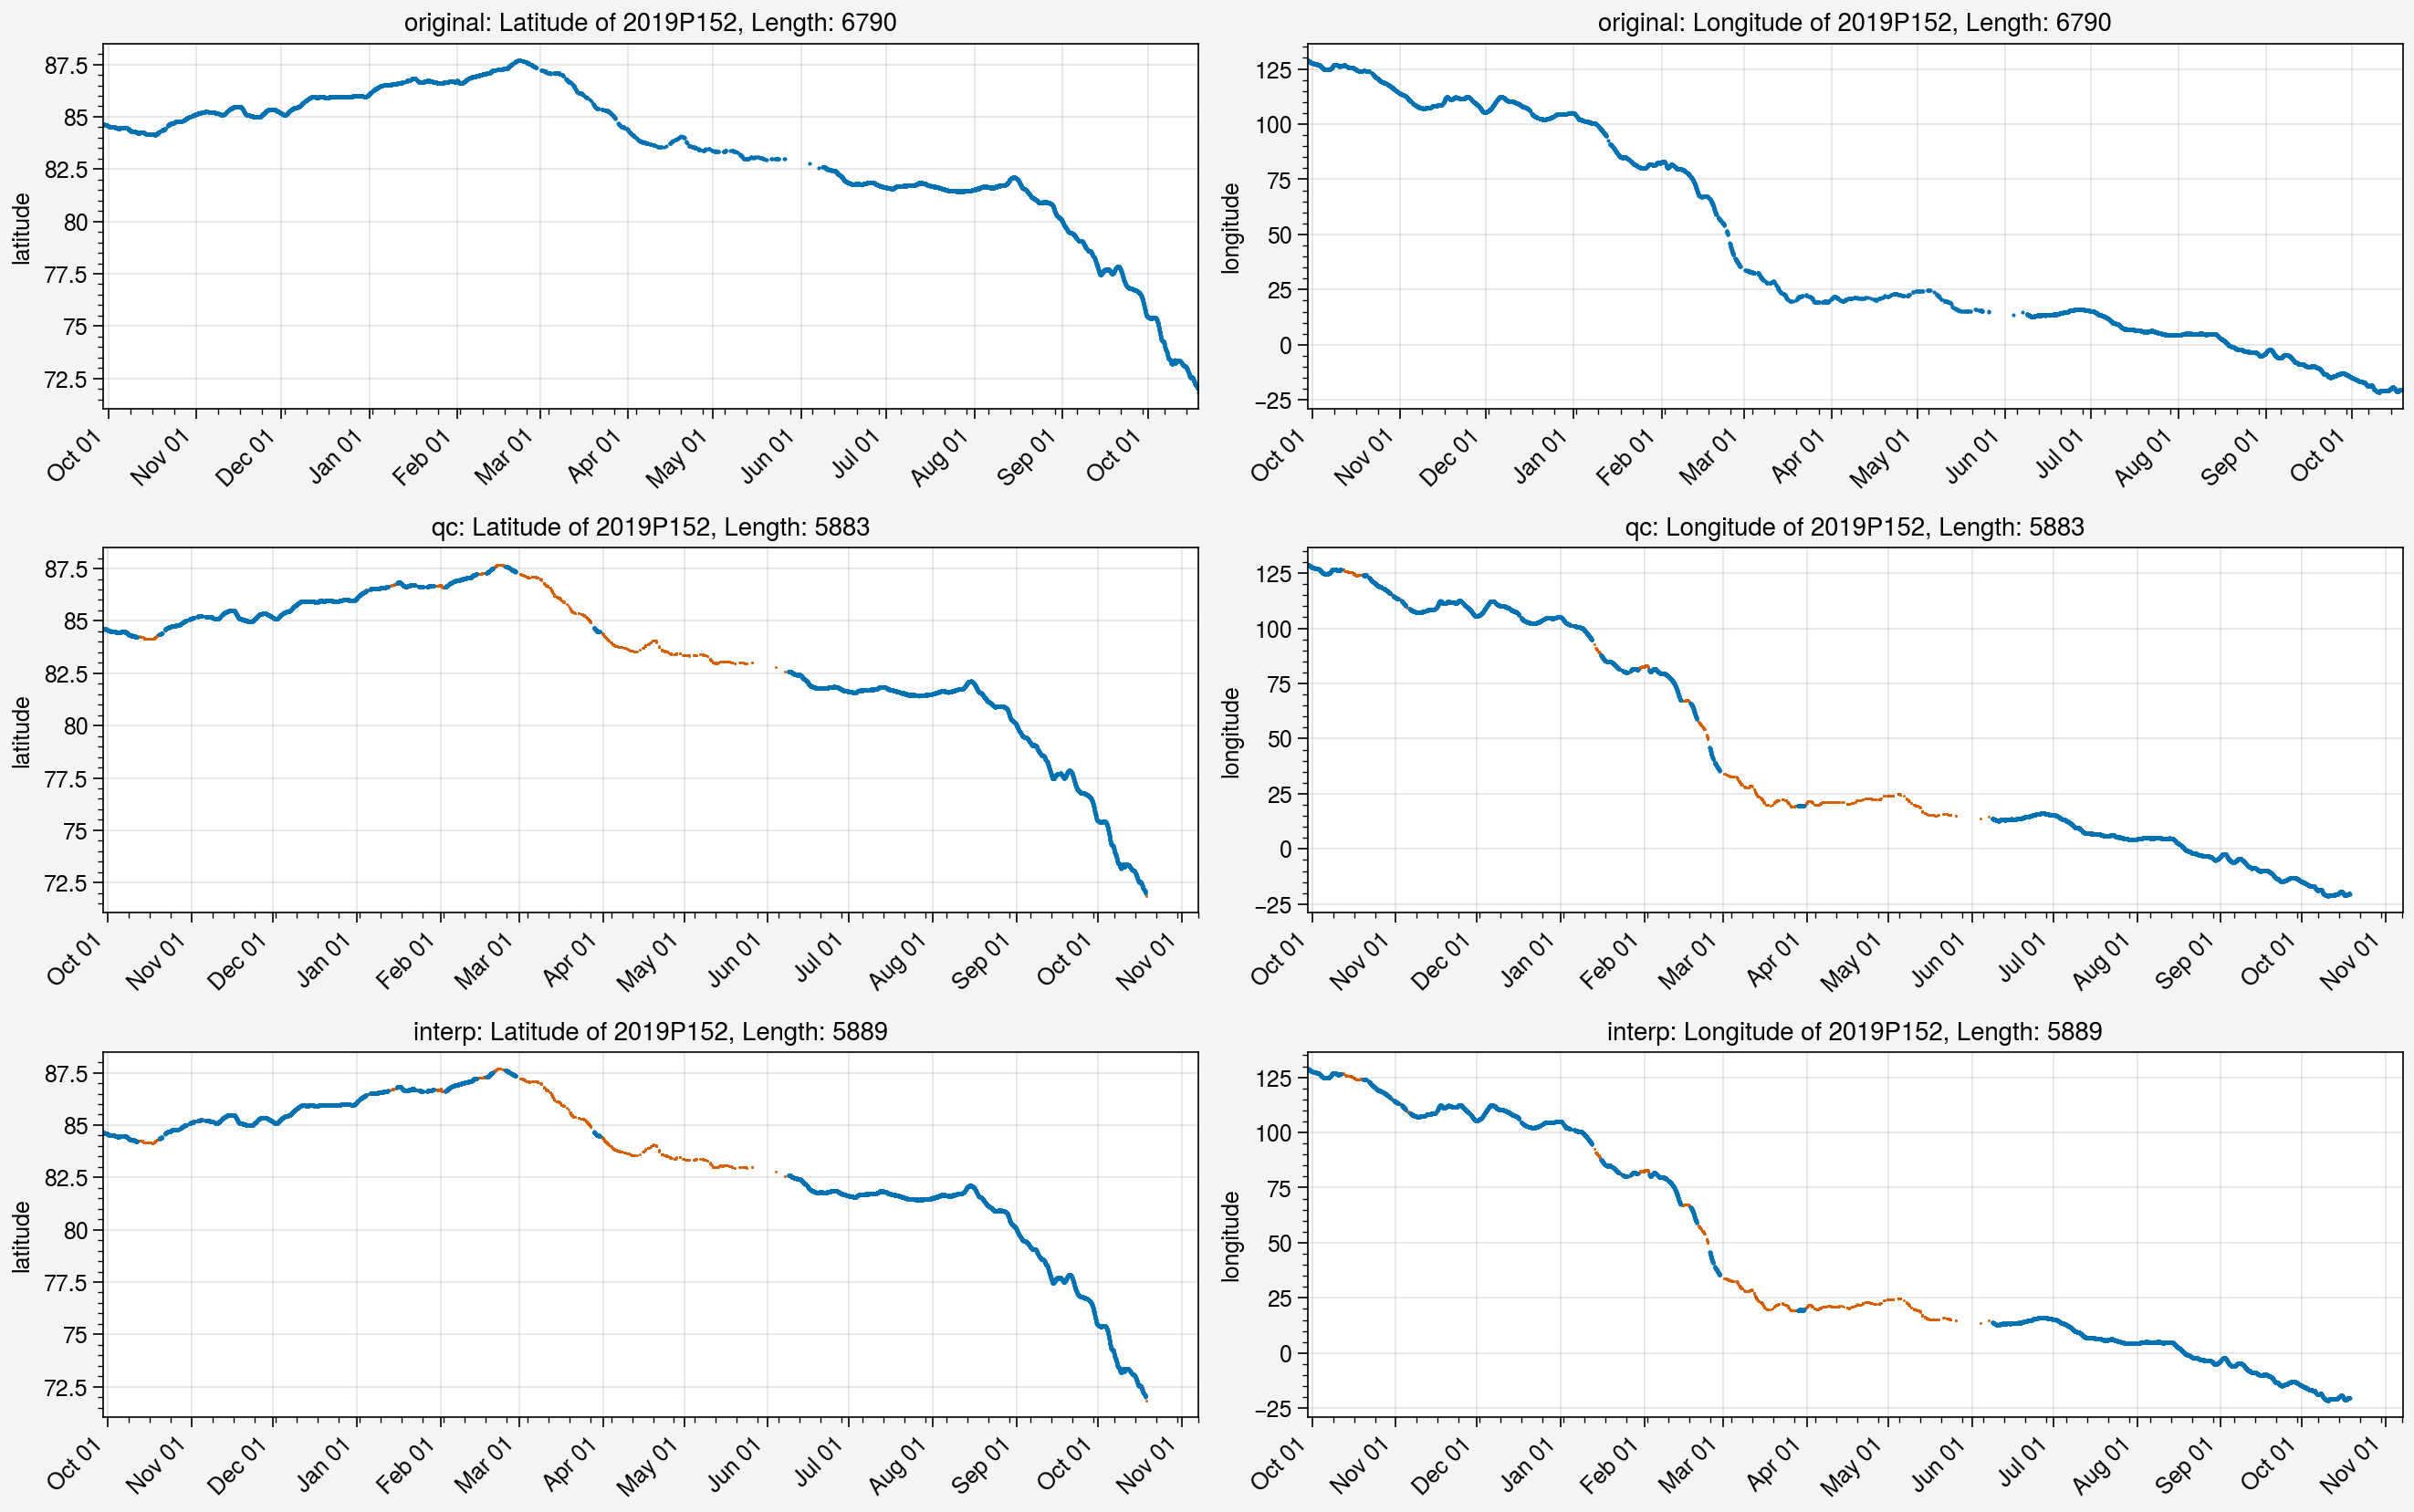

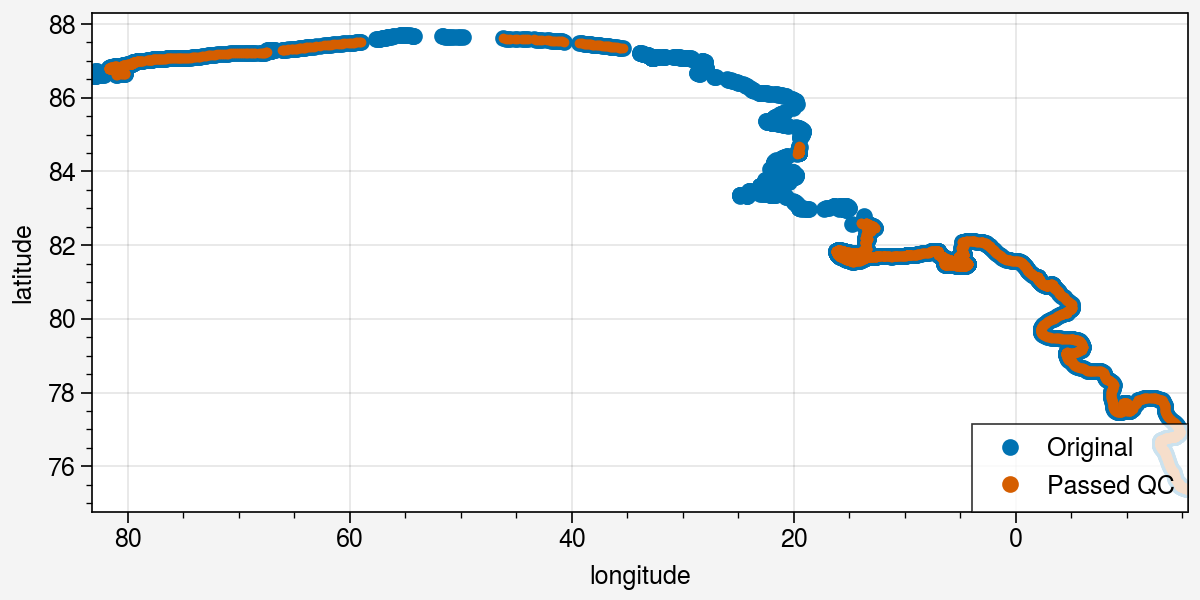

In [15]:
# I graphed a random buoy chosen from above and set the graphs to show which points were removed

graph_data('2019P152', showcleaned=True)

time_slice = slice('2020-02-01', '2020-10-01')

orig_df = buoy_data('2019P152', 'original').set_index('datetime')
qc_df = buoy_data('2019P152', 'qc').set_index('datetime')
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(orig_df.loc[time_slice, 'longitude'],
        orig_df.loc[time_slice, 'latitude'], m='.', ms=10, lw=0, label='Original')
ax.plot(qc_df.loc[time_slice, 'longitude'],
        qc_df.loc[time_slice, 'latitude'], m='.', ms=5, lw=0, label='Passed QC')
ax.legend(loc='lr', ncols=1, markersize=10)


<a list of 1 Line2D objects>

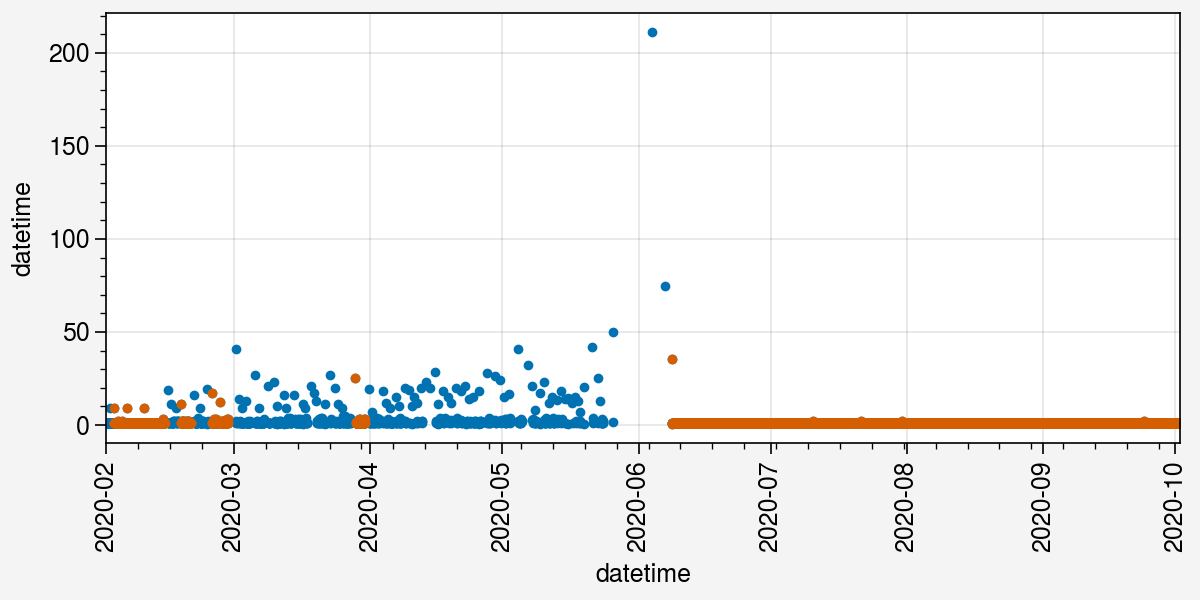

In [16]:
time_since_previous = orig_df.index.to_series() - orig_df.index.to_series().shift(1)
time_since_previous = time_since_previous.dt.total_seconds()/(60*60) # conver to hours
fig, ax = pplt.subplots(width=6, height=3)
ax.plot(time_since_previous.loc[time_slice], marker='.', ms=5, lw=0)
ax.plot(time_since_previous.loc[qc_df.index].loc[time_slice], marker='.', ms=5, lw=0)

In this case, our frequency is 1 hour, so the code sets gap_threshold to 3 hours. This would explain the removal of the short segments that are 3 hours away from other segments. The QC on this one is very dramatic, as a result of the often sparse data from mid February 2020 to mid June 2020. After mid June, it seems data collection became more stable.

# 5.

/home/alanxw/.micromamba/envs/sea-ice-utra/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "


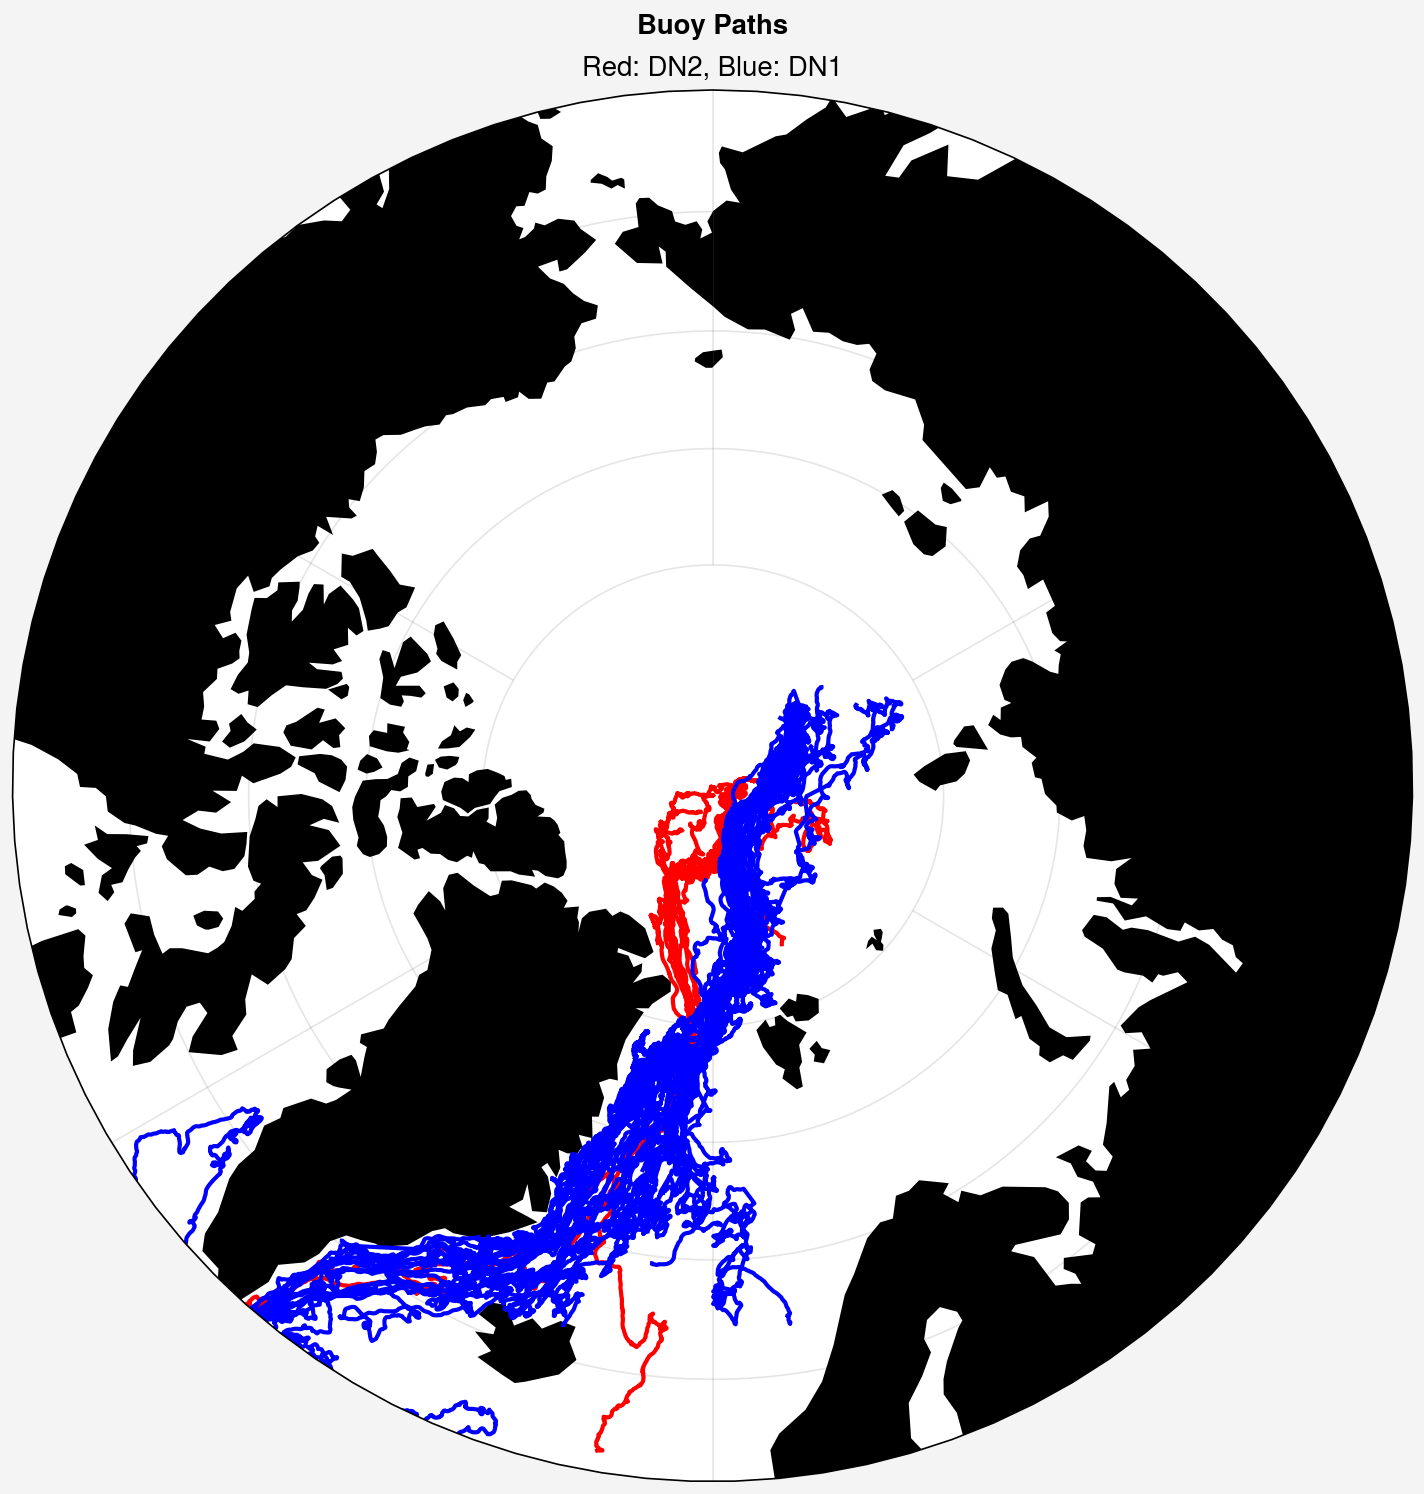

In [17]:
# Pole-centered map projections

fig, axs = pplt.subplots(ncols=1, refwidth=7, proj=('npstere'))
fig.format(suptitle='Buoy Paths')
axs.format(land=True)

dn1 = os.listdir("../data/interp_buoys/mosaic_dn1")
dn2 = os.listdir("../data/interp_buoys/mosaic_dn2")

axs[0].format(boundinglat=60, title='Red: DN2, Blue: DN1')

# Plot dn2 buoys in red, dn1 buoys in blue
for buoy in [i[:-4] for i in dn2]:
    axs[0].plot(buoy_data(buoy)['longitude'], buoy_data(buoy)['latitude'], color="red")
for buoy in [i[:-4] for i in dn1]:
    axs[0].plot(buoy_data(buoy)['longitude'], buoy_data(buoy)['latitude'], color="blue")
